In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time
import sys
import math
from pixell import enmap, enplot, reproject, utils, curvedsky 
from astropy.io import ascii, fits
import astropy.coordinates as coord
import astropy.table as atpy
import astropy.units as u
import plotly
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
from astropy.visualization import make_lupton_rgb
import random 
import os

In [2]:
# set paths to maps
path90 = "/Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f090_daynight_map.fits"
path150 = "/Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f150_daynight_map.fits"
path220 = "/Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f220_daynight_map.fits"

In [15]:
f90 = fits.open(path90)
f90.info()

Filename: /Volumes/SeaGate 1/ACT/act_dr5.01_s08s18_AA_f090_daynight_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  FREQ-MAP      1 PrimaryHDU      45   (43200, 10320, 3)   float32   


In [50]:
data.shape

(3, 10320, 43200)

In [5]:
def eshow(x,**kwargs): 
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [3]:
ra_dp = [0, 360]
dec_dp = [-60, 23]
ra_from, ra_to = np.deg2rad(ra_dp)
dec_from, dec_to = np.deg2rad(dec_dp)

box = [[dec_from,ra_from],[dec_to,ra_to]]

imap90 = enmap.read_map(path90, box = box)
# imap150 = enmap.read_map(path150, box = box)
# imap220 = enmap.read_map(path220, box = box)

In [10]:
imap90[0].shape

(9960, 43200)

In [ ]:
freqs = [(imap90, 90), (imap150, 150), (imap220, 220)]

In [6]:
tab = atpy.Table().read('DR5_cluster-catalog_v1.1.fits')
ras = tab['RADeg']
decs = tab['decDeg']
mass = tab['M500c']
dist = tab['redshift']

df = pd.DataFrame(dict(
    Ra = list(ras),
    Dec = list(decs),
    Mass500 = list(mass),
    RedShift = list(dist),
    SNR = list(tab['SNR']),
    y_coord = [0.0] * len(ras),
    x_coord = [0.0] * len(ras)
))
work_glx = df.loc[(df['SNR'] > 8.5)]
for ind, g in work_glx.iterrows():
    dec = g['Dec']
    ra = g['Ra']
    coords = np.deg2rad(np.array((dec,ra)))
    work_glx.at[ind, 'y_coord'], work_glx.at[ind, 'x_coord'] = enmap.sky2pix(imap90.shape, imap90.wcs, coords)

In [6]:
work_glx

Ra        Dec   Mass500  RedShift        SNR      y_coord  \
10      0.300925 -48.719495  2.540051  0.346400   8.605525  1353.660579   
24      0.802528  -6.089387  6.456959  0.233369  19.971769  6469.273619   
27      0.935321  10.024777  4.251252  0.369317   8.725429  8402.973270   
30      0.992414  16.701807  4.319113  1.305200  14.811408  9204.216783   
33      1.268260  -1.644033  3.017171  0.979202  11.583759  7002.715980   
...          ...        ...       ...       ...        ...          ...   
4148  358.065849 -46.956089  3.313355  0.919266  12.138137  1565.269263   
4156  358.547906   2.666611  2.905048  0.226283   9.653370  7519.993265   
4190  359.727531 -43.905169  2.639904  0.734463   8.750438  1931.379673   
4191  359.887357   2.138787  2.722980  0.429373   9.269819  7456.654494   
4193  359.929865 -50.169857  2.980008  0.775000   8.924190  1179.617156   

           x_coord  
10       36.110957  
24       96.303403  
27      112.238579  
30      119.089630  
33      152.191258  
...            ...  
4148  42967.901917  
4156  43025.748733  
4190  43167.303720  
4191  43186.482833  
4193  43191.583798  

[599 rows x 7 columns]

In [ ]:
path = 'dataset/'
height, width  = imap90.shape[1], imap90.shape[2]
box_width, box_height = 100, 100
start_h, start_w = 0, 0
curr_h, curr_w = start_h, start_w
coef = np.array([1.44509305, -0.16399278])
bias = -2.1075201676682633
img_counter = 0
while (curr_h < height):
    curr_w = start_w
    while (curr_w < width):
        tmp = work_glx.loc[(work_glx['y_coord'] > curr_h) & (work_glx['y_coord'] < curr_h + box_height) 
                           & (work_glx['x_coord'] > curr_w) & (work_glx['x_coord'] < curr_w + box_width)]
        if len(tmp) > 0:
            fig = plt.figure(frameon=False)
            fig.set_size_inches(2, 2)
            ax = plt.Axes(fig, [0., 0., 1., 1.])
            ax.set_axis_off()
            fig.add_axes(ax)
            res = imap90[0][curr_h:curr_h+box_height, curr_w:curr_w + box_width]
#             res = res.clip(0, 1)
            for ind, row in tmp.iterrows():
#                 x, y = row['x_coord'], row['y_coord']
#                 radius = min(row['Mass500'] * coef[0] + row['RedShift'] * coef[1] + bias, 5)
#                 ax.scatter(math.floor(x) - curr_w, math.floor(y) - curr_h, color='red', s=1, lw=0)
#                 a_circle = plt.Circle((math.floor(x) - curr_w, math.floor(y) - curr_h), round(radius), color='white')
#                 ax.add_artist(a_circle)
                min_el = np.amin(res)
                ax.imshow(res, vmin=min_el, vmax=abs(min_el), aspect='auto', cmap='gray')
            if not os.path.exists(path):
                os.makedirs(path)
            fig.savefig(path + '/{}_id_{}_90_fq.png'.format(img_counter, ind), dpi=50, pad_inches=0)
            img_counter += 1
            plt.close()
        curr_w += 80
    curr_h += 80

In [ ]:
width = 40/60
glx = [3185, 2870, 3267, 3030, 3274]
fig, axs = plt.subplots(len(glx), 1, figsize=(30, 25))
for i, j in enumerate(glx):
    ra, dec = df.loc[j]['Ra'], df.loc[j]['Dec']
    box = np.deg2rad([[dec - width / 2.,ra - width / 2.],[dec + width / 2.,ra + width / 2.]])
    fig.tight_layout()
    axs[i].set_title('Id {}'.format(j))
    res = imap90[0].submap(box)
    axs[i].set_xlabel("Mass500={}, Z={}".format(df.loc[j]['Mass500'], df.loc[j]['RedShift']))
    axs[i].imshow(res, cmap='coolwarm')
    axs[i].grid(True)
# fig.savefig("kek.png")

KeyboardInterrupt: 

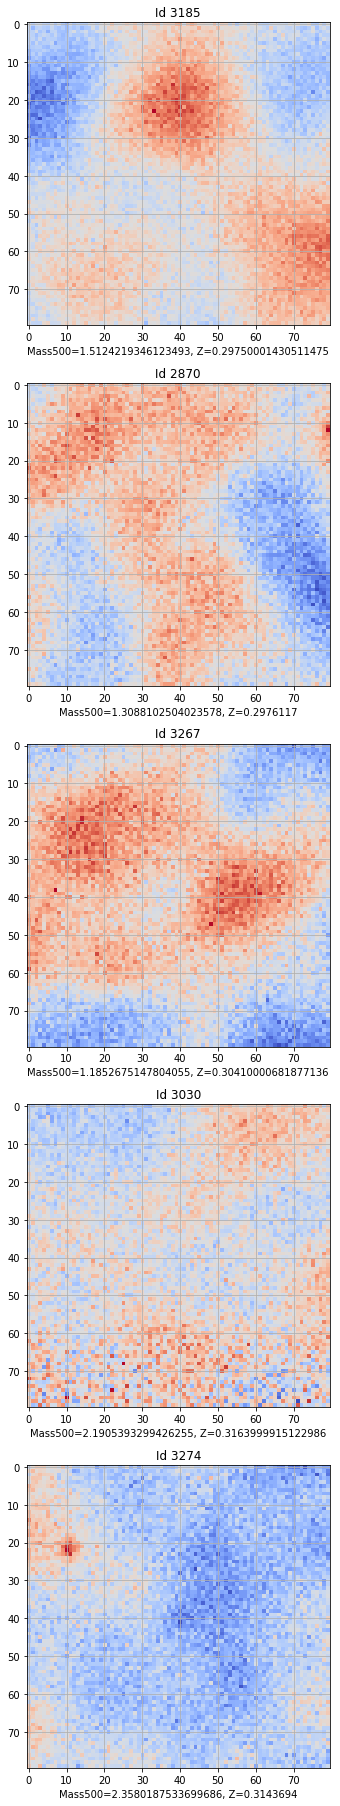

In [119]:
width = 60/60
glx = [3185, 2870, 3267, 3030, 3274]
fig, axs = plt.subplots(len(glx), 1, figsize=(30, 25))
for i, j in enumerate(glx):
    ra, dec = df.loc[j]['Ra'], df.loc[j]['Dec']
    box = np.deg2rad([[dec - width / 2.,ra - width / 2.],[dec + width / 2.,ra + width / 2.]])
    fig.tight_layout()
    axs[i].set_title('Id {}'.format(j))
    res = imap90[0].submap(box)
    axs[i].set_xlabel("Mass500={}, Z={}".format(df.loc[j]['Mass500'], df.loc[j]['RedShift']))
    axs[i].imshow(res, cmap='coolwarm')
    axs[i].grid(True)

In [207]:
fig = px.scatter(df, x='Mass500', y='RedShift', hover_name=df.index.tolist(), hover_data=["Dec", "Ra"],)
fig.show()

In [40]:
width = 50/60.

(360, 360)


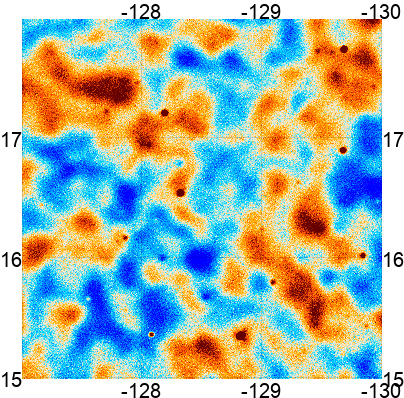

In [116]:
# fig, axs = plt.subplots(1, 1, figsize=(8, 6))    
width = 3
ra, dec = 231.5, 16.5
box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
res = imap90[0].submap(box)
print(res.shape)
eshow(res)

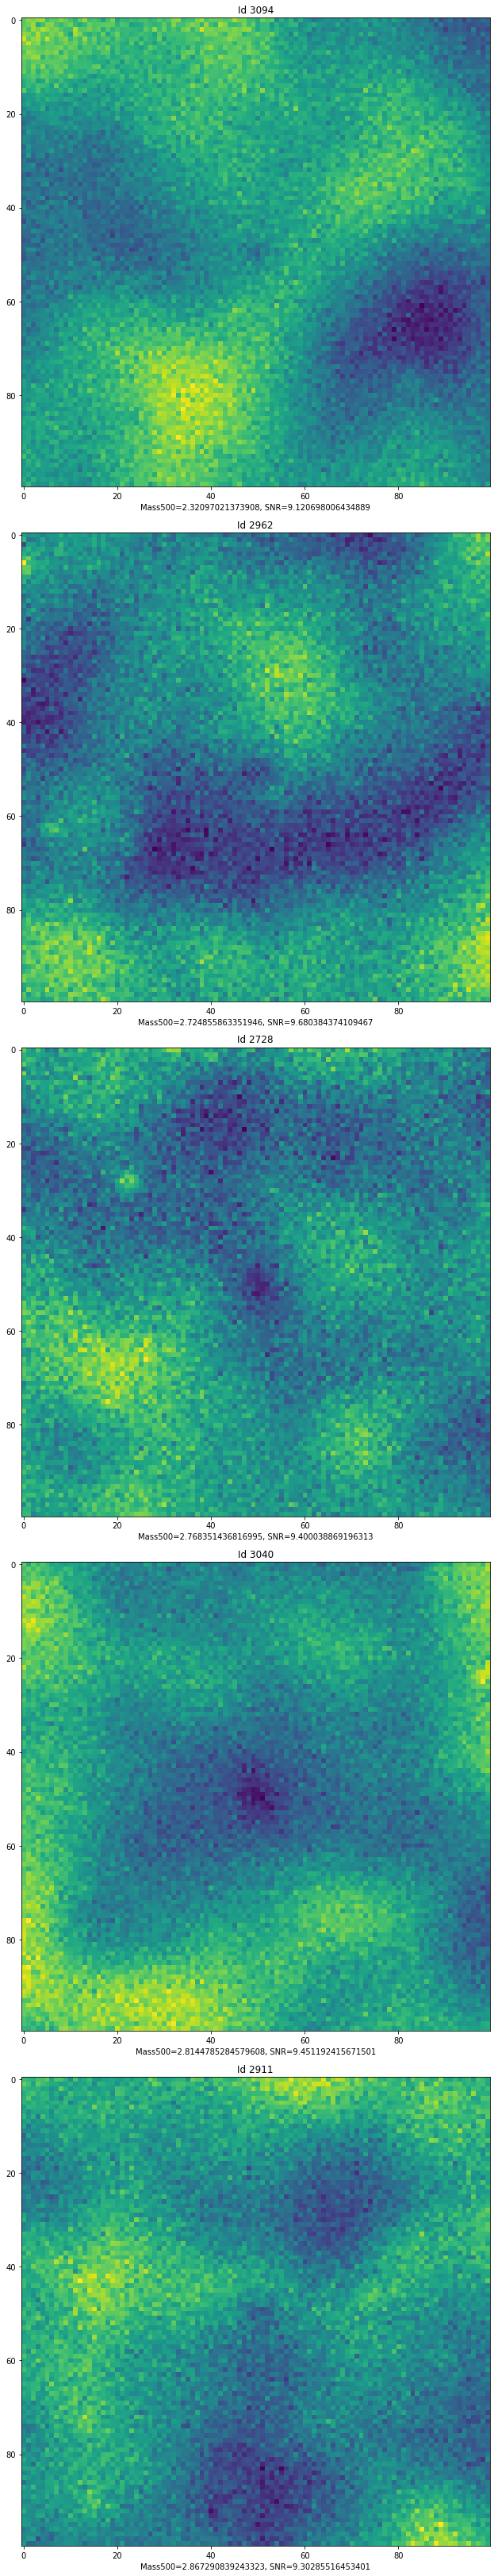

In [308]:
fig, axs = plt.subplots(glx.shape[0], 1, figsize=(50, 45))
for i, obj in enumerate(glx.iterrows()):
    ra, dec = obj[1]['Ra'], obj[1]['Dec']
    box = np.deg2rad([[dec - width / 2.,ra - width / 2.],[dec + width / 2.,ra + width / 2.]])
    fig.tight_layout()
    axs[i].set_title('Id {}'.format(obj[0]))
    res = imap90[0].submap(box)
    axs[i].set_xlabel("Mass500={}, SNR={}".format(obj[1]['Mass500'], obj[1]['SNR']))
    axs[i].imshow(res)

In [258]:
curr_z = 0.29
beam = 1
beam_m = 0.05

In [54]:
tmp = df.loc[
             (df['Ra'] > ra_dp[0]) & (df['Ra'] < ra_dp[1]) & (df['Dec'] > dec_dp[0]) 
             & (df['Dec'] < dec_dp[1]) & (df['SNR'] > 9)]
# (df['RedShift'] > curr_z - beam) & (df['RedShift'] < curr_z + beam) 
to_concat = []
mass = 2.8
glx = tmp.sort_values(['Mass500'])[::].head()
glx

Ra        Dec   Mass500  RedShift       SNR  y_coord  x_coord
3094  228.682416  13.782192  2.320970  1.059000  9.120698      0.0      0.0
522    20.880527  -4.475098  2.527838  1.427600  9.806854      0.0      0.0
2964  218.862394  11.827015  2.573499  0.683000  9.126959      0.0      0.0
395    16.229387   0.054831  2.589496  0.272921  9.637133      0.0      0.0
3158  233.288377   8.227001  2.674667  0.615633  9.024226      0.0      0.0

In [318]:
path = 'patches/'
width = 50/60.
a = []
for ind, row in glx.iterrows():
    fig = plt.figure(frameon=False)
    fig.set_size_inches(2, 2)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    dec, ra = row['Dec'], row['Ra']
    box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
    res = imap90[0].submap(box)
    ax.scatter([res.shape[0] //2], [res.shape[0] // 2], color='red', s=1, lw=0)
    ax.imshow(res, aspect='auto', cmap='viridis')
    directory = path + 'z{}'.format(curr_z)
    if not os.path.exists(directory):
        os.makedirs(directory)
    fig.savefig(directory + '/M{}.png'.format(row['Mass500']), dpi=50, pad_inches=0)
    plt.close()
    a.append(ind)
a

[3488, 2205, 3371, 3911, 3551]

826.255 -217.11862


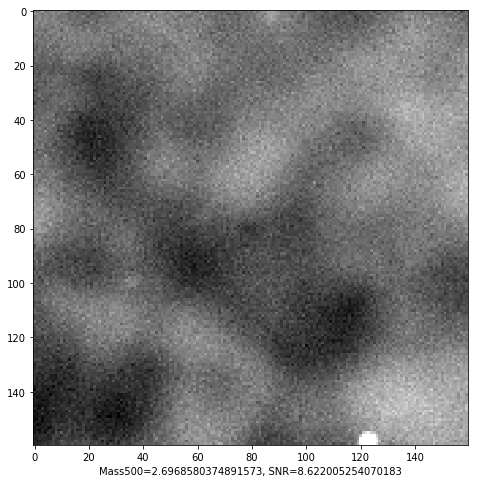

In [101]:
# 3239, 2882, 3219, 3228, 3136
i = 2796
width = 80/60.
a = 1
b = 2
fig, axs = plt.subplots(1, 1, figsize=(8, 8))    
ra, dec = df['Ra'].iloc[i], df['Dec'].iloc[i]
box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
res = imap90[0].submap(box)

min_el = np.amin(res)
max_el = np.max(res)
print(np.max(res), min_el)
axs.set_xlabel("Mass500={}, SNR={}".format(df.loc[i]['Mass500'], df.loc[i]['SNR']))
# axs.imshow(res)
axs.imshow(res, vmin=min_el, vmax=abs(min_el)*1, cmap='gray')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations

/Library/Frameworks/Python.framework/Versions/3.7/lib/py

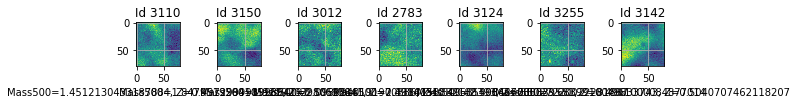

In [151]:
fig, axs = plt.subplots(1, len(glx), figsize=(8, 5))
for i, obj in enumerate(glx.iterrows()):
    ra, dec = obj[1]['Ra'], obj[1]['Dec']
    box = np.deg2rad([[dec - width / 2.,ra - width / 2.],[dec + width / 2.,ra + width / 2.]])
    fig.tight_layout()
    axs[i].set_title('Id {}'.format(obj[0]))
    res = imap90[0].submap(box)
#     a_circle = plt.Circle((res.shape[0] //2, res.shape[0] //2), 2, color='red')
#     axs[i].add_artist(a_circle)
    axs[i].set_xlabel("Mass500={}, Z={}".format(obj[1]['Mass500'], obj[1]['RedShift']))
    axs[i].imshow(res)
    axs[i].grid(True)

In [326]:
print(glx)
print(imap90.shape)
for ind, g in glx.iterrows():
    dec = g['Dec']
    ra = g['Ra']
    coords = np.deg2rad(np.array((dec,ra)))
    ypix,xpix = enmap.sky2pix(imap90.shape, imap90.wcs, coords)
    print(ypix, xpix)

              Ra        Dec   Mass500  RedShift       SNR
3094  228.682416  13.782192  2.320970    1.0590  9.120698
2962  218.508154   7.022773  2.724856    0.7034  9.680384
2728  201.844347   3.627851  2.768351    0.2250  9.400039
2537  187.509315  17.011230  2.808671    0.9686  9.240821
3288  244.352540  15.807013  2.828076    0.3370  9.296127
(3, 9600, 31200)
8853.863024001657 15441.889909154343
8042.7328081652595 14220.978521209297
7635.342151290395 12221.321590549676
9241.347544946348 10501.11778020201
9096.8415466101 17322.30474398259


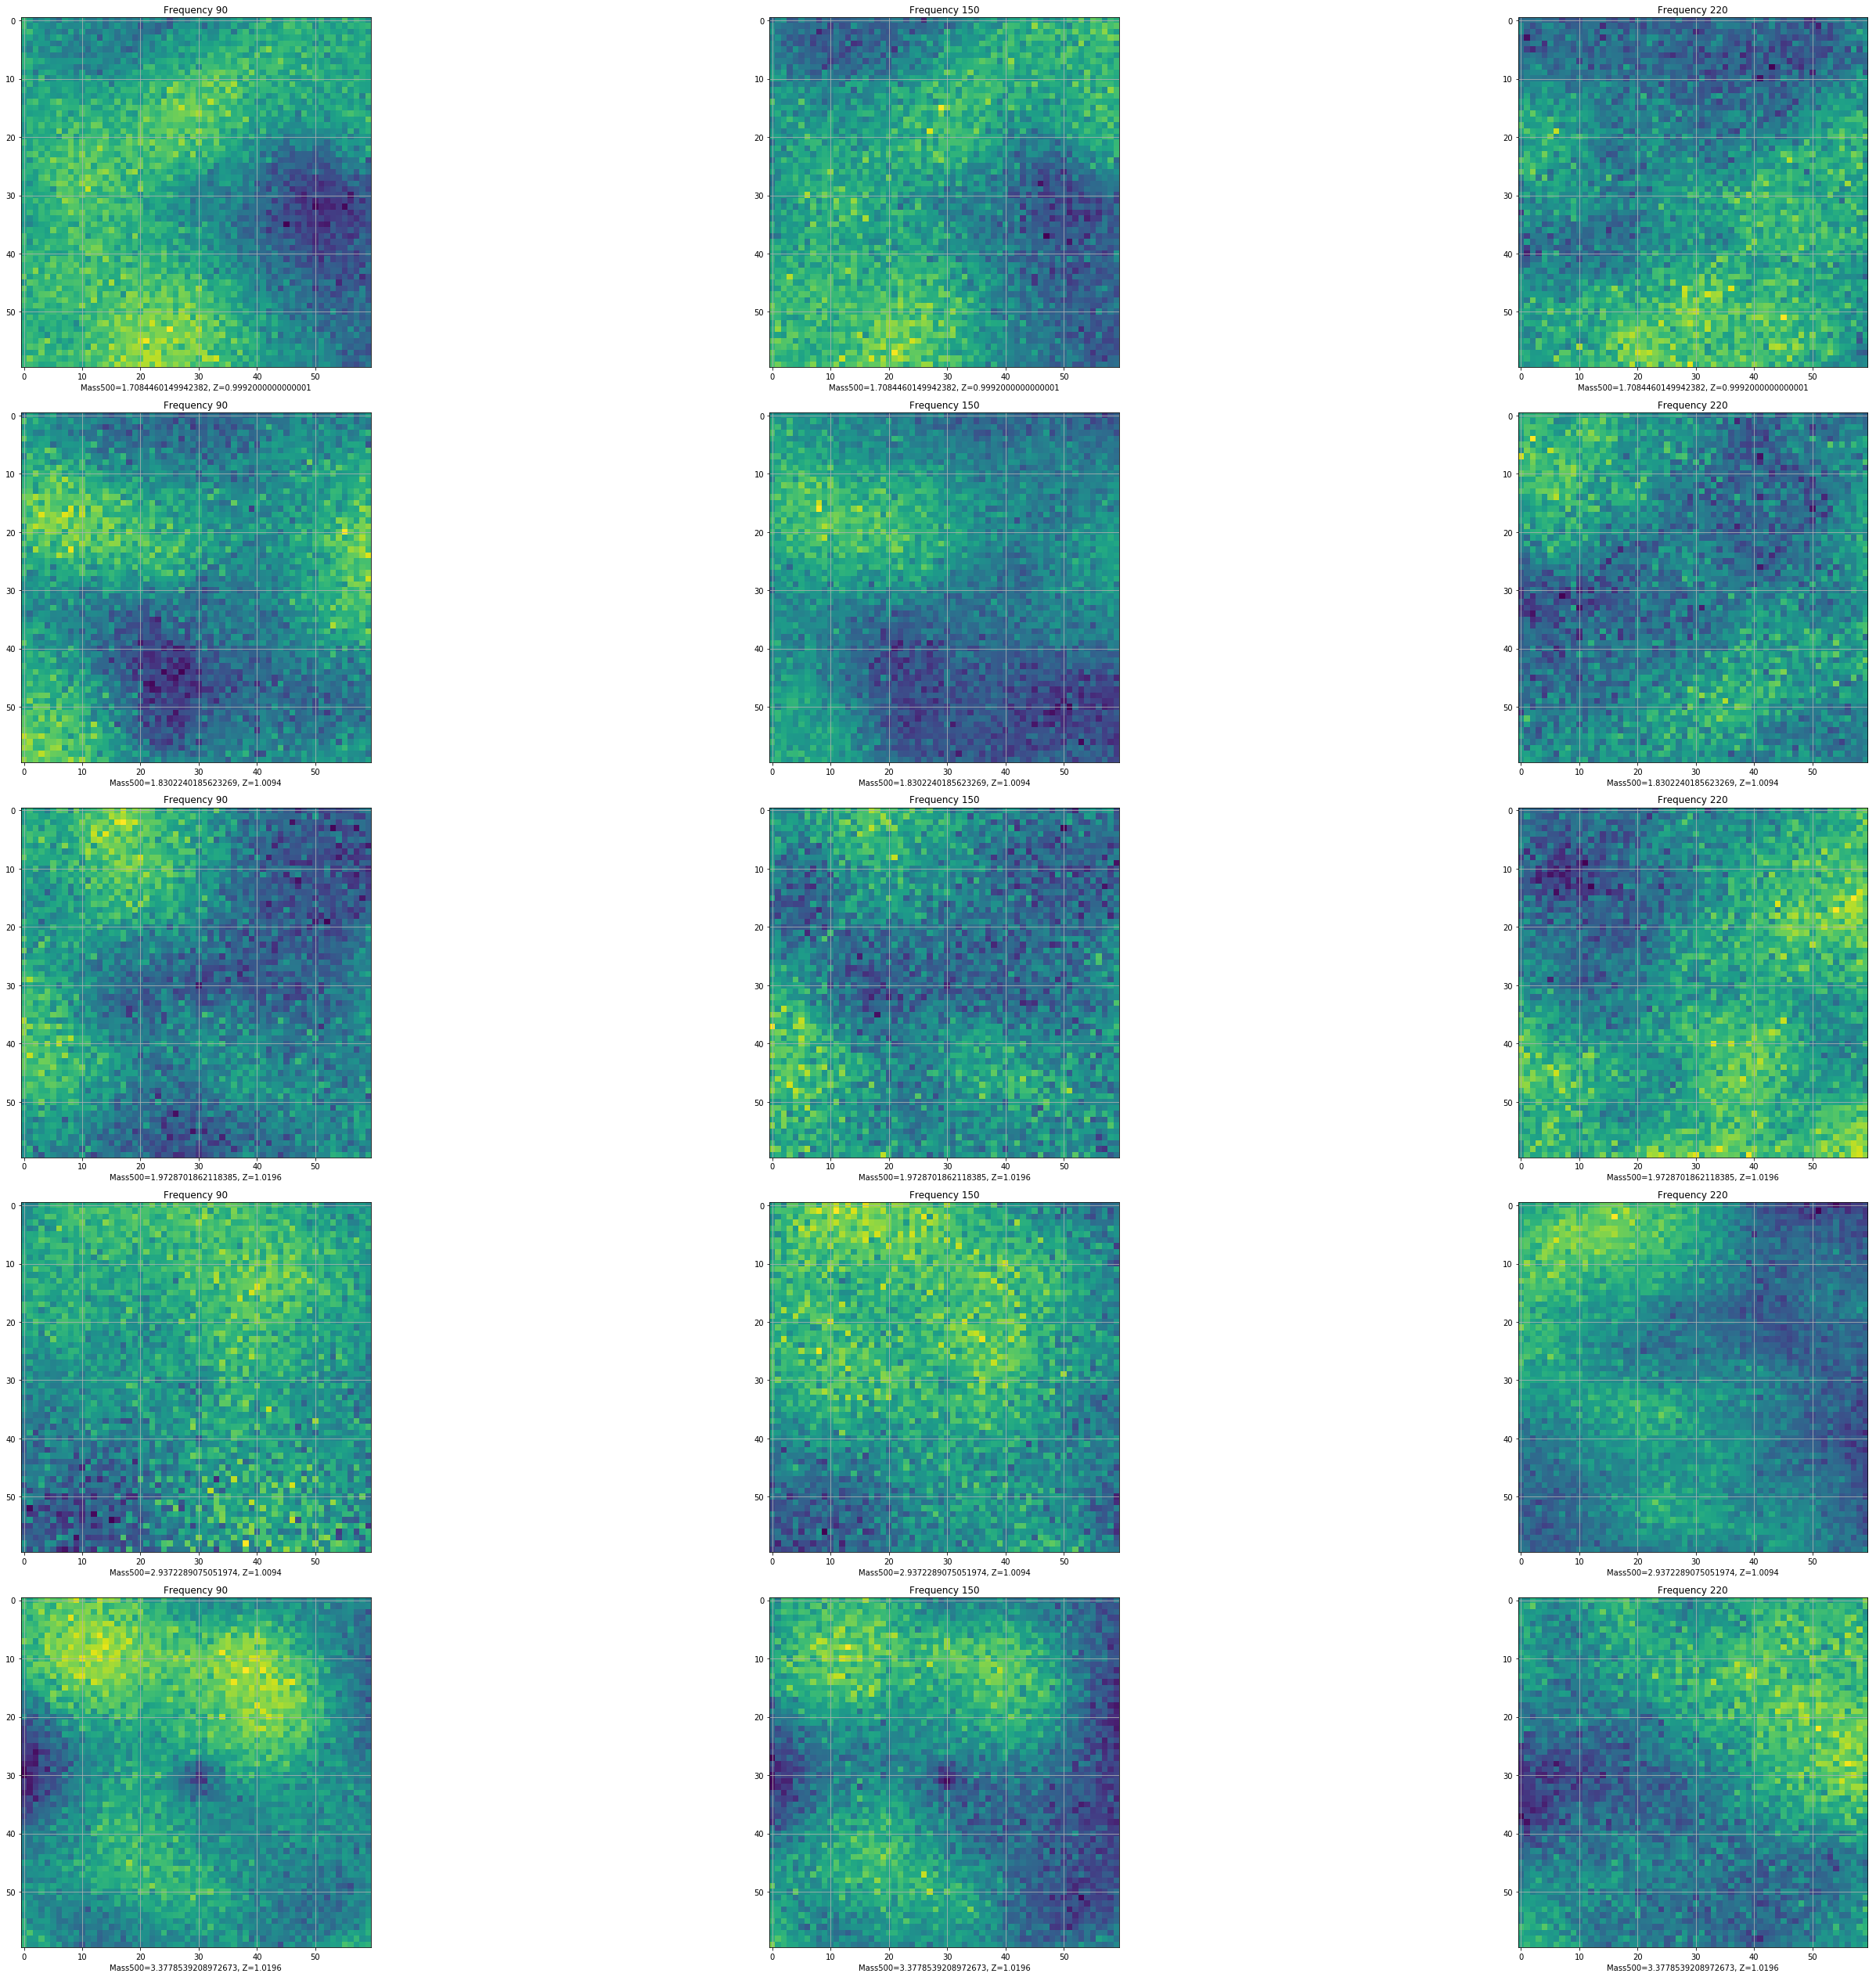

In [193]:
width = 30/60
len(glx)
fig, axs = plt.subplots(len(glx), 3, figsize=(40, 35))
for i, obj in enumerate(glx.iterrows()):
    ra, dec = obj[1]['Ra'], obj[1]['Dec']
    box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
    fig.tight_layout()
    for j, imap in enumerate(freqs):
        axs[i][j].imshow(imap[0][0].submap(box))
        axs[i][j].set_title('Frequency {}'.format(imap[1]))
        axs[i][j].set_xlabel("Mass500={}, Z={}".format(obj[1]['Mass500'], obj[1]['RedShift']))
        axs[i][j].grid(True)
fig.savefig("z=0.1.png")

In [567]:
galaxies

[6, 18, 28, 32, 37]

Text(0.5, 0, 'Degrees')

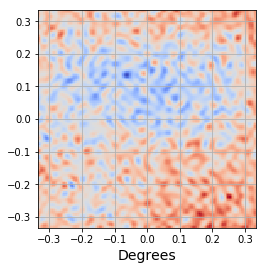

In [107]:
r_arcmin = 10.  #Define the radius of the image in arcminutes
r = r_arcmin*np.pi/(60 * 180)  # convert arcminutes to radiagalaxies 

stamp = reproject.thumbnails(imap90, coords = np.deg2rad([decs[n], ras[n]]), res =  0.0000454440, r = r)


extent = [-r_arcmin/30., r_arcmin/30., -r_arcmin/30., r_arcmin/30.]
plt.imshow(stamp[0], extent=extent,cmap = cm.coolwarm)
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)

Text(0.5, 0, 'Degrees')

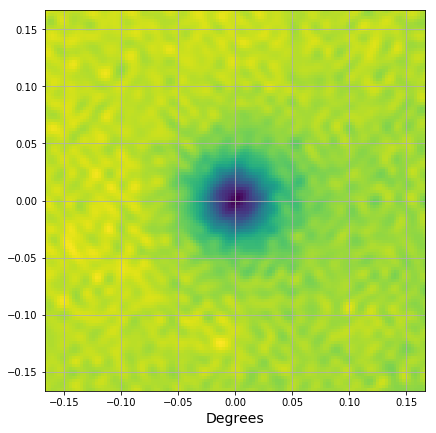

In [95]:
stamps = reproject.thumbnails(imap90[0], coords=np.deg2rad([decs,ras]).T, res=0.0000454440, r=r)
stack = np.mean(stamps,0)

plt.figure(figsize = (7,7))
plt.imshow(stack, extent = extent)
plt.grid(True)
plt.xlabel("Degrees", fontsize = 14)